## Use adaptive boundary mesh to estimate the result

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
from lenstronomy.Util.util import make_grid
from lenstronomy.Data.pixel_grid import PixelGrid
import importlib

In [3]:
import abm          # adaptive boundary mesh

In [4]:
d_l = 4000  # distance of the lens in pc
d_s = 8000  # distance of the source in pc
# diameter of milky way 50kpc
# distance from solar to milky way centre 8kpc

# ===========
# lens system
# ===========

M0 = 1e3  # typical mass of IMBH in units of M_sol

# ===========
# source size
# ===========

diameter_s = 1  # size of the radius of the source star in units of the solar radius

In [5]:
# compute lensing properties
from lenstronomy.Cosmo.micro_lensing import einstein_radius, source_size

theta_E = einstein_radius(M0, d_l, d_s)
print(theta_E, 'Einstein radius [arc seconds]')

size_s = source_size(diameter_s, d_s)
print(size_s, 'source size [arc seconds]')

0.03191026155192734 Einstein radius [arc seconds]
1.163118159836867e-06 source size [arc seconds]


In [6]:
# map image to source plane
lens = LensModel(lens_model_list=['POINT_MASS'])
kwargs_lens = [{'theta_E': theta_E, 'center_x': theta_E/2, 'center_y': 0}]

result from lens equ solver

In [26]:
from lenstronomy.PointSource.point_source import PointSource
# unlensed source positon #
point_source_model_list = ['SOURCE_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list,
                           lens_model=lens, fixed_magnification_list=[True], kwargs_lens_eqn_solver={
                               'min_distance': 1e-3
                           })
kwargs_ps = [{'ra_source': 0, 'dec_source': 0, 'source_amp': 10}]
pointSource.image_position(kwargs_ps, kwargs_lens)/theta_E

array([[[-7.80776406e-01,  1.28077641e+00]],

       [[-7.72259587e-15,  3.63343333e-12]]])

In [7]:
beta_s = size_s/2

pixel_size, xx, yy = abm.adaptive_boundary_mesh(
    source_position=(0, 0), L=theta_E*4, beta_0=theta_E*16, beta_s=beta_s, lensModel=lens, kwargs_lens=kwargs_lens, verbose=False
)

In [110]:
print('amplification', pixel_size**2*len(xx)/(np.pi*beta_s**2))

amplification 2.1828294896426215


<Axes: xlabel='x', ylabel='y'>

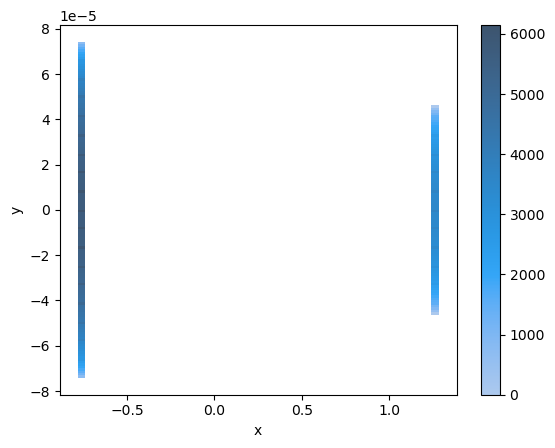

In [29]:
import seaborn as sns
sns.histplot({'x': xx/theta_E, 'y': yy/theta_E}, x='x', y='y', cbar=True)

theoretically, the amplification

In [13]:
u = 0.5
A = (u*u+2)/(u*(np.sqrt(u*u+4)))
print(A)

2.182820625326997


my purpose: digitize the ray tracing result into a figure of low resolution(but higher than the target resolution) and convolve it with a psf, downgrade the figure to get the final figure.

In [8]:
from scipy.stats import binned_statistic_2d

In [38]:
fig_size = 8*theta_E
resolution = 1e-5
Npix = int(fig_size/resolution)
x_coor = y_coor = np.arange(Npix)*resolution - fig_size/2

In [39]:
result = binned_statistic_2d(x=xx, y=yy, values=None, statistic='count', bins=[x_coor, y_coor])

In [40]:
(result.statistic > 0).sum()

3

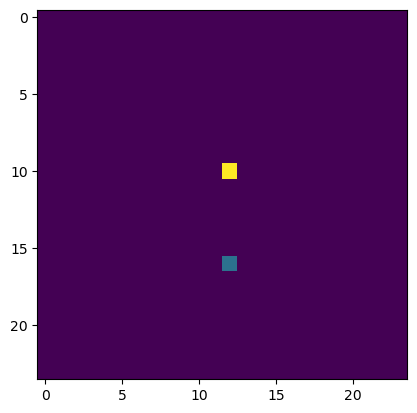

In [29]:
plt.imshow(result.statistic)